In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import constants, units
from astropy.coordinates import Angle
from scipy.optimize import curve_fit
import pandas as pd
import os

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/'

Load in the MUSE FITS file

In [3]:
muse_fits = fits.open(rootdir + 'COMBINED_CUBE_MED_FINAL_vac_sub_15_pix.fits')

In [4]:
muse_fits.info()

Filename: /Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/MUSE/COMBINED_CUBE_MED_FINAL_vac_sub_15_pix.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1211   ()      
  1  DATA          1 ImageHDU        42   (337, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (337, 319, 3682)   float32   


In [5]:
data_hdu = muse_fits[1]
var_hdu = muse_fits[2]

In [6]:
data_hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  337 / Axis lenght                                    
NAXIS2  =                  319 / Axis lenght                                    
NAXIS3  =                 3682 / Axis lenght                                    
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

In [7]:
var_hdu.header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  337 / Axis lenght                                    
NAXIS2  =                  319 / Axis lenght                                    
NAXIS3  =                 3682 / Axis lenght                                    
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'STAT    '           / This extension contains data variance          
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

Extract the MUSE cube as a 3-D array

In [8]:
spec_cube = data_hdu.data.copy()
var_cube = var_hdu.data.copy()

In [9]:
spec_cube.shape, var_cube.shape

((3682, 319, 337), (3682, 319, 337))

Extract the wavelength array

In [10]:
wav_0 = data_hdu.header['CRVAL3']
del_wav = data_hdu.header['CD3_3']

In [11]:
wav_arr = np.arange(wav_0, wav_0 + (spec_cube.shape[0]-1)*del_wav, del_wav)

Extract the RA array

In [12]:
RA_ref_pix = data_hdu.header['CRPIX1']-1
RA_ref_val = data_hdu.header['CRVAL1']
del_RA = data_hdu.header['CD1_1']

In [13]:
RA_0_val = RA_ref_val - del_RA*RA_ref_pix

In [14]:
RA_arr = np.arange(RA_0_val, RA_0_val + spec_cube.shape[2]*del_RA, del_RA)

In [15]:
RA_arr_deg = [Angle(ra, units.degree) for ra in RA_arr]

In [16]:
RA_arr_hms = [ra.hms for ra in RA_arr_deg]

In [17]:
RA_arr_labels = [str(int(ra[0])) + 'h' + str(int(ra[1])) + 'm' + str(np.round(ra[2],2)) + 's' 
                 for ra in RA_arr_hms]

Extract Dec array

In [18]:
Dec_ref_pix = data_hdu.header['CRPIX2']-1
Dec_ref_val = data_hdu.header['CRVAL2']
del_Dec = data_hdu.header['CD2_2']

In [19]:
Dec_0_val = Dec_ref_val - del_Dec*Dec_ref_pix

In [20]:
Dec_arr = np.arange(Dec_0_val, Dec_0_val + spec_cube.shape[1]*del_Dec, del_Dec)

In [21]:
Dec_arr_deg = [Angle(dec, units.degree) for dec in Dec_arr]

In [22]:
Dec_arr_dms = [dec.dms for dec in Dec_arr_deg]

In [23]:
Dec_arr_labels = [str(int(dec[0])) + 'd' + str(int(dec[1])) + 'm' + str(np.round(dec[2],2)) + 's' 
                 for dec in Dec_arr_dms]

Make the flux map at a fixed wavelength (say the 1819th card)

In [24]:
wav_arr[0], wav_arr[-1]

(4751.284541786687, 9352.534541786688)

In [25]:
n = 3170

In [26]:
wav = wav_arr[n]

In [27]:
spec_arr = spec_cube[n, :, :]
var_arr = var_cube[n, :, :]

In [28]:
spec_arr_flat = spec_arr.flatten()
min_flux = np.nanpercentile(spec_arr_flat, 1)
max_flux = np.nanpercentile(spec_arr_flat, 99)

In [29]:
qso_ref_pix_x = 168 
qso_ref_pix_y = 162

r_1 = 0

circ_x_1 = [qso_ref_pix_x + r_1*np.cos(p) for p in np.linspace(0, 2*np.pi, 100)]
circ_y_1 = [qso_ref_pix_y + r_1*np.sin(p) for p in np.linspace(0, 2*np.pi, 100)]

r_2 = 1

circ_x_2 = [qso_ref_pix_x + r_2*np.cos(p) for p in np.linspace(0, 2*np.pi, 100)]
circ_y_2 = [qso_ref_pix_y + r_2*np.sin(p) for p in np.linspace(0, 2*np.pi, 100)]

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_9008/1177424267.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_9008/1177424267.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


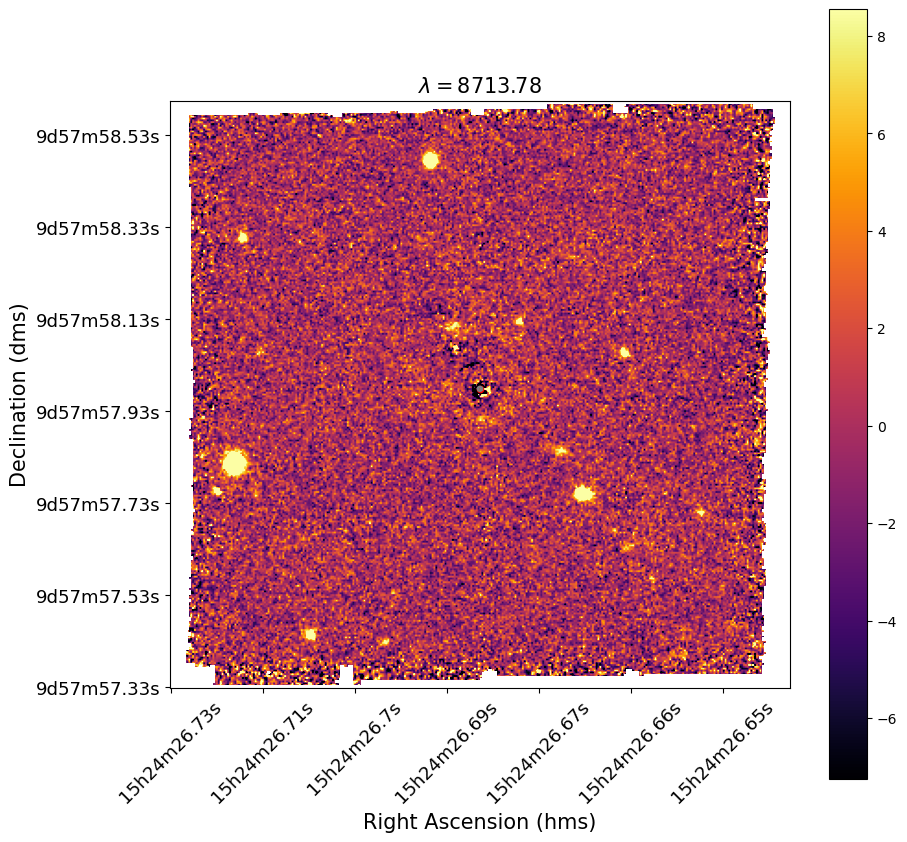

In [30]:
fig, ax = plt.subplots(1, figsize=(10,10))

im = ax.imshow(spec_arr, vmin = min_flux, vmax = max_flux, cmap='inferno')
plt.colorbar(im)

ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav, 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_9008/1633760192.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_9008/1633760192.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels, fontsize=13)


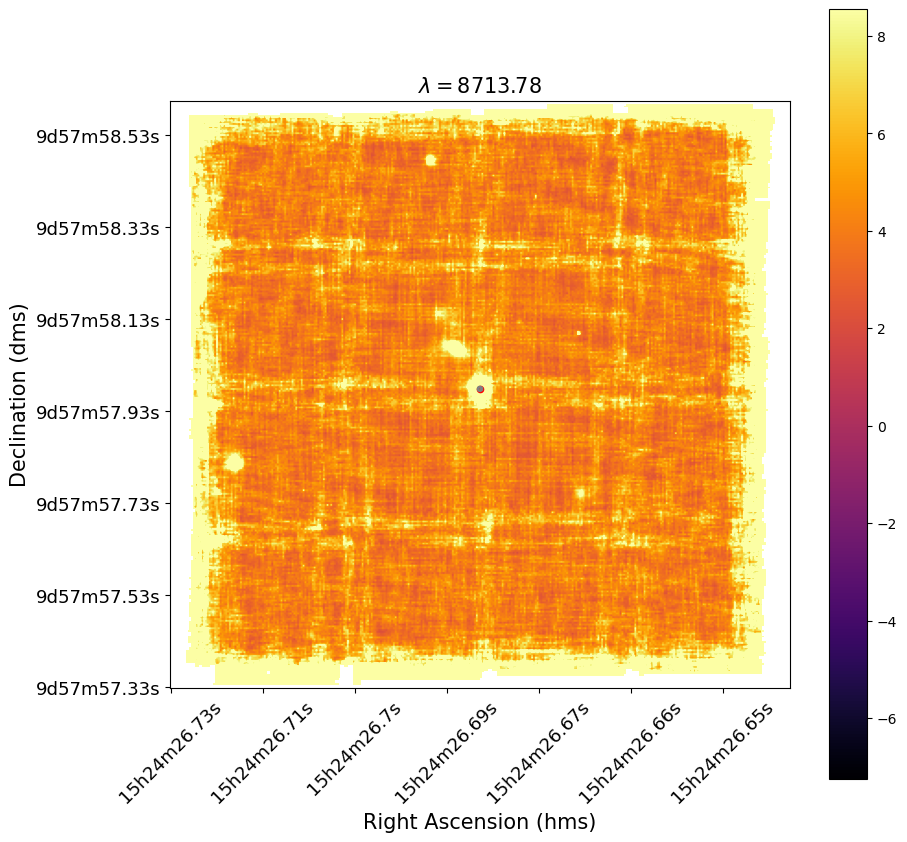

In [31]:
fig, ax = plt.subplots(1, figsize=(10,10))

im = ax.imshow(var_arr, vmin = min_flux, vmax = max_flux, cmap='inferno')
plt.colorbar(im)

ax.plot(circ_x_1, circ_y_1, color='gray', lw=2)
ax.plot(circ_x_2, circ_y_2, color='gray', lw=2)

ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s= 20)

ax.set_title(r'$\lambda = $' + str(np.round(wav, 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels, rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels, fontsize=13)

ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

Create the spectral file

In [32]:
coord_arr = [227, 105]
a = 1
b = 1
tilt = 25

In [33]:
x0 = coord_arr[0]-1
y0 = coord_arr[1]-1
theta = tilt*np.pi/180

disc_x_pix = []
disc_y_pix = []

for j in range(spec_cube.shape[2]):
    for k in range(spec_cube.shape[1]):

        j_prime = (j-x0)*np.cos(theta) + (k-y0)*np.sin(theta)
        k_prime = -(j-x0)*np.sin(theta) + (k-y0)*np.cos(theta)

        d = (j_prime/a)**2 + (k_prime/b)**2

        if(d<=1):
            disc_x_pix.append(j)
            disc_y_pix.append(k)

flux_gal = np.zeros(len(disc_x_pix))
spec_stack = np.zeros((len(disc_x_pix), len(wav_arr)))
var_stack = np.zeros((len(disc_x_pix), len(wav_arr)))

for l in range(len(disc_x_pix)):

    x = disc_x_pix[l]
    y = disc_y_pix[l]

    flux_gal[l] = np.nansum(spec_cube[:,y,x])
    spec_stack[l,:] = spec_cube[:,y,x]
    var_stack[l,:] = var_cube[:,y,x]

min_flux_gal = np.nanpercentile(flux_gal, 75)
max_flux_gal = np.nanpercentile(flux_gal, 100)

idx_bright = (flux_gal>=min_flux_gal) & (flux_gal<=max_flux_gal)

gal_spec = np.nanmean(spec_stack[idx_bright], axis=0)
gal_spec_err = np.sqrt(np.nansum(var_stack[idx_bright], axis=0))/len(disc_x_pix)

/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_9008/51561781.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(RA_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix],
/var/folders/tj/vc_wjrpj36sf3zws4s7s770c0000gn/T/ipykernel_9008/51561781.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(Dec_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix], fontsize=13)


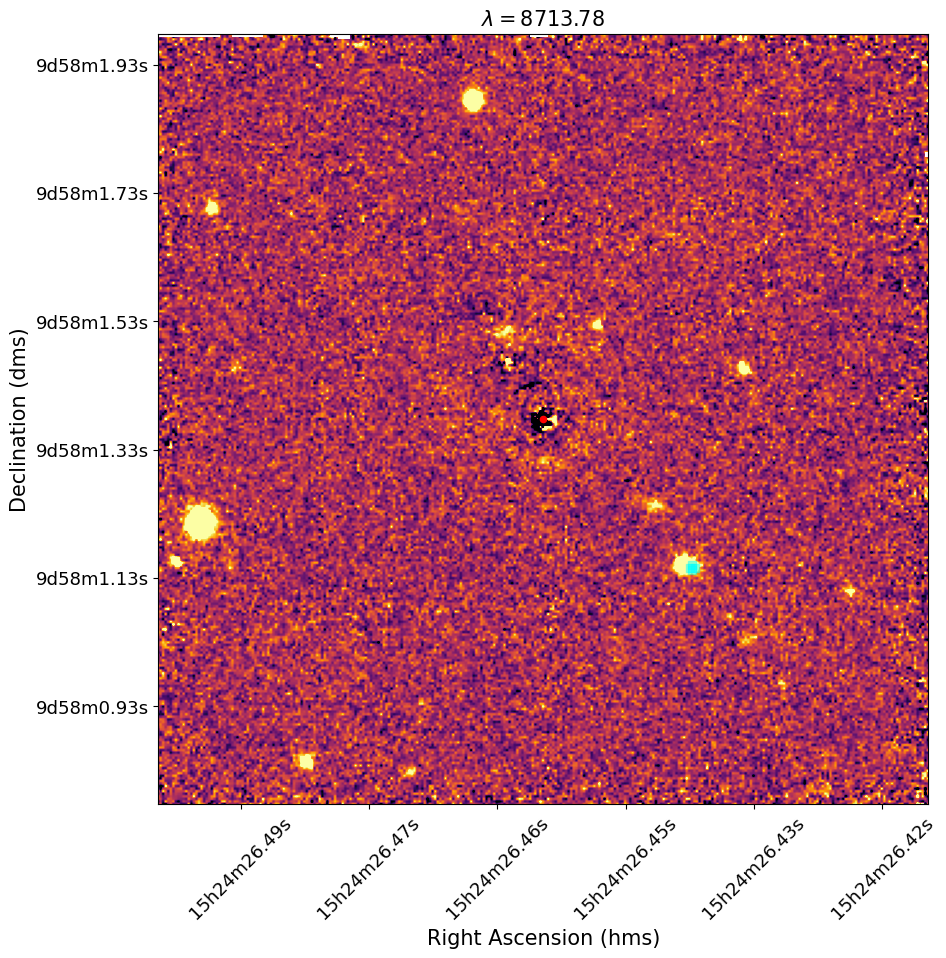

In [34]:
fig, ax = plt.subplots(1, figsize=(10,10))

qso_window_pix = 150

ax.imshow(spec_arr, vmin = min_flux, vmax = max_flux, cmap='inferno')
ax.scatter(disc_x_pix, disc_y_pix, marker='s', color='cyan', alpha=.4)

ax.scatter(qso_ref_pix_x, qso_ref_pix_y, color='red', s=20)

ax.set_title(r'$\lambda = $' + str(np.round(wav, 2)), fontsize=15)
ax.set_xticklabels(RA_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix], 
                   rotation=45, fontsize=13)
ax.set_yticklabels(Dec_arr_labels[qso_ref_pix_x-qso_window_pix:qso_ref_pix_x+qso_window_pix], fontsize=13)


ax.set_xlim(qso_ref_pix_x-qso_window_pix, qso_ref_pix_x+qso_window_pix)
ax.set_ylim(qso_ref_pix_y+qso_window_pix, qso_ref_pix_y-qso_window_pix)


ax.set_xlabel('Right Ascension (hms)', fontsize=15)
ax.set_ylabel('Declination (dms)', fontsize=15)

ax.invert_yaxis()

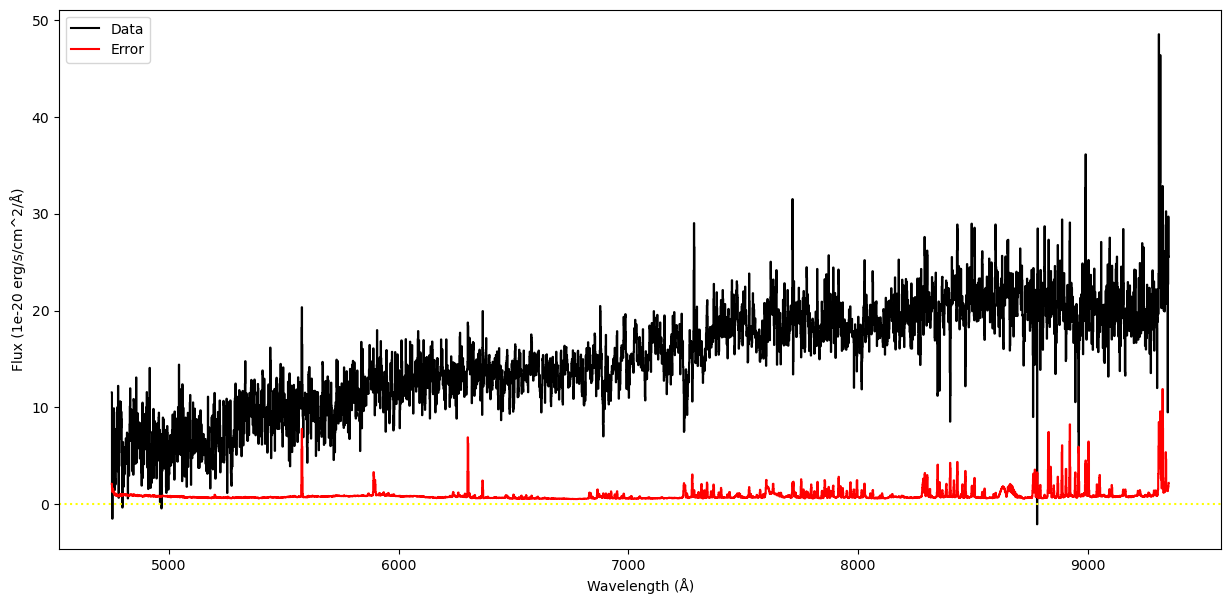

In [35]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.step(wav_arr, gal_spec, where='mid', color='black', label='Data')
ax.step(wav_arr, gal_spec_err, where='mid', color='red', label='Error')
ax.axhline(0, linestyle=':', color='yellow')


ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux (1e-20 erg/s/cm^2/Å)')

#ax.set_ylim(0,7.2)
ax.legend()

Save everything

In [145]:
np.savetxt(rootdir + 'gali7_spec.dat',
              np.vstack((wav_arr, gal_spec, gal_spec_err, )).T, delimiter='\t')

Load in template spectra

In [36]:
eigenspec_df = pd.read_csv('/Users/thepoetoftwilight/Documents/CUBS/Data/Eigenspectra/eigen_galaxy_Bolton2012.csv')

In [37]:
wav_eigen = eigenspec_df['wav']
c1 = eigenspec_df['c1']
c2 = eigenspec_df['c2']
c3 = eigenspec_df['c3']
c4 = eigenspec_df['c4']

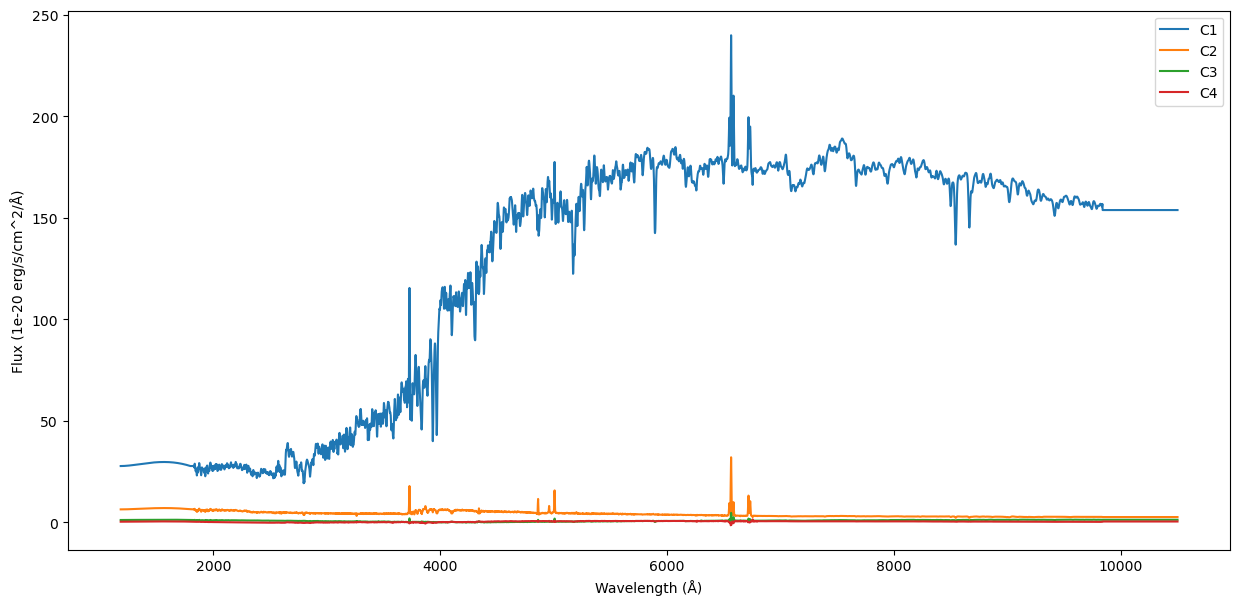

In [38]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_eigen, c1, label='C1')
ax.plot(wav_eigen, c2, label='C2')
ax.plot(wav_eigen, c3, label='C3')
ax.plot(wav_eigen, c4, label='C4')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux (1e-20 erg/s/cm^2/Å)')

ax.legend()

In [39]:
def z_shift_eigen(z, wav_arr):
    
    wav_eigen_shift = wav_eigen*(1+z)
    
    gal_ind = (wav_eigen_shift>=wav_arr[0])&(wav_eigen_shift<=wav_arr[-1])
    wav_eigen_shift_gal = wav_eigen_shift[gal_ind]
    
    c1_gal = c1[gal_ind]
    c1_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c1_gal)

    c2_gal = c2[gal_ind]
    c2_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c2_gal)
    
    c3_gal = c3[gal_ind]
    c3_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c3_gal)

    c4_gal = c4[gal_ind]
    c4_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c4_gal)
    
    return c1_gal_interp, c2_gal_interp, c3_gal_interp, c4_gal_interp

In [40]:
def best_model(c1, c2, c3, c4, y, y_err):

    A11 = np.sum((c1/y_err)**2)
    A12 = np.sum(c1*c2/y_err**2)
    A13 = np.sum(c1*c3/y_err**2)
    A14 = np.sum(c1*c4/y_err**2)
    
    A21 = np.sum(c2*c1/y_err**2)
    A22 = np.sum((c2/y_err)**2)
    A23 = np.sum(c2*c3/y_err**2)
    A24 = np.sum(c2*c4/y_err**2)
    
    A31 = np.sum(c3*c1/y_err**2)
    A32 = np.sum(c3*c2/y_err**2)
    A33 = np.sum((c3/y_err)**2)
    A34 = np.sum(c3*c4/y_err**2)
    
    A41 = np.sum(c4*c1/y_err**2)
    A42 = np.sum(c4*c2/y_err**2)
    A43 = np.sum(c4*c3/y_err**2)
    A44 = np.sum((c4/y_err)**2)
    
    b1 = np.sum(y*c1/y_err**2)
    b2 = np.sum(y*c2/y_err**2)
    b3 = np.sum(y*c3/y_err**2)
    b4 = np.sum(y*c4/y_err**2)
    
    A_mat = np.array([[A11, A12, A13, A14],[A21, A22, A23, A24],[A31, A32, A33, A34],[A41, A42, A43, A44]])
    b_vec = np.array([b1, b2, b3, b4])
    
    x_vec = np.linalg.inv(A_mat)@b_vec
    
    a = x_vec[0]
    b = x_vec[1]
    c = x_vec[2]
    d = x_vec[3]

    return a, b, c, d

In [41]:
def eval_red_chi_sq(y_hat, y, y_err, dof):
    
    return np.sum(((y-y_hat)/y_err)**2)/(len(y)-dof)

Do the redshift fitting now

In [50]:
z_arr = np.arange(0.8,1.4,1e-4)
red_chi_sq_arr = np.zeros(len(z_arr))

In [51]:
model_params = np.zeros((len(z_arr), 4))

In [52]:
idx = ~np.isnan(gal_spec)

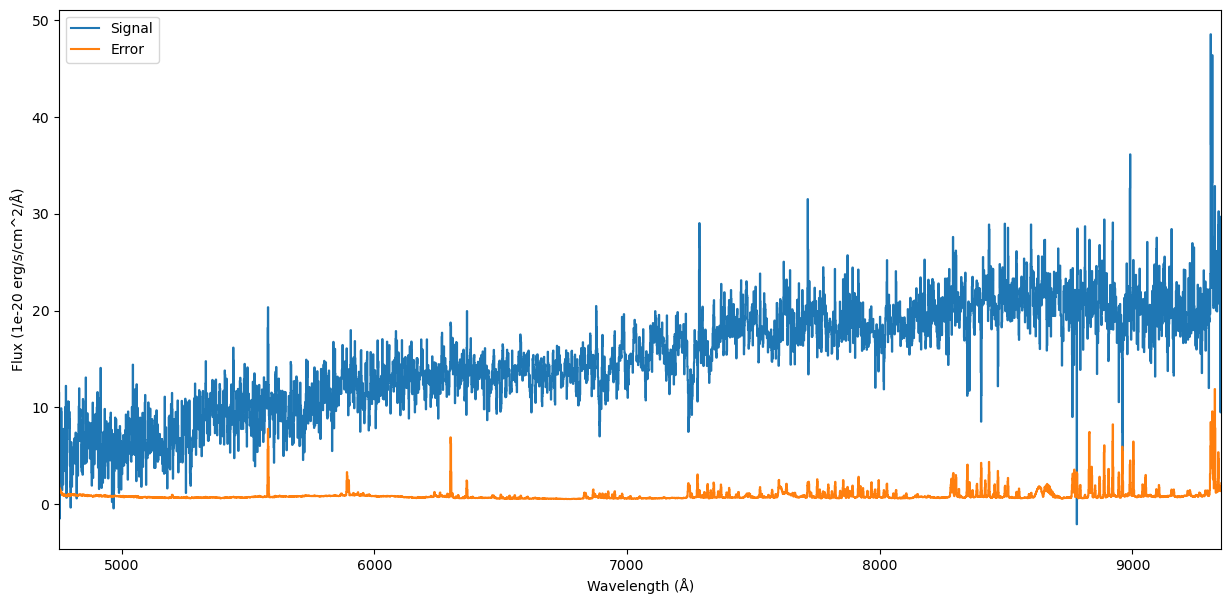

In [53]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.step(wav_arr, gal_spec, label='Signal', where='mid')
ax.step(wav_arr, gal_spec_err, label='Error', where='mid')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux (1e-20 erg/s/cm^2/Å)')

#wav_lower = 8640
#wav_upper = 8780

wav_lower = wav_arr[0]
wav_upper = wav_arr[-1]

ax.set_xlim(wav_lower, wav_upper)

ax.legend()

In [54]:
n_lower = np.where((wav_arr>=wav_lower)&(wav_arr<=wav_upper))[0][0]
n_upper = np.where((wav_arr>=wav_lower)&(wav_arr<=wav_upper))[0][-1]

In [55]:
for i in range(len(z_arr)):
    
    z = z_arr[i]
    
    c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr[idx][n_lower:n_upper])
    
    a, b, c, d = best_model(c1_shift, c2_shift, c3_shift, c4_shift, 
                            gal_spec[idx][n_lower:n_upper], gal_spec_err[idx][n_lower:n_upper])
    
    model_params[i,0] = a
    model_params[i,1] = b
    model_params[i,2] = c
    model_params[i,3] = d 
    
    red_chi_sq = eval_red_chi_sq(a*c1_shift+b*c2_shift+c*c3_shift+d*c4_shift, 
                                        gal_spec[idx][n_lower:n_upper], 
                                 gal_spec_err[idx][n_lower:n_upper], model_params.shape[1])
    
    red_chi_sq_arr[i] = red_chi_sq
    
    #print(a, b, c, d, red_chi_sq)

Plot the best solution

0.8442999999999952 12.104322583143997


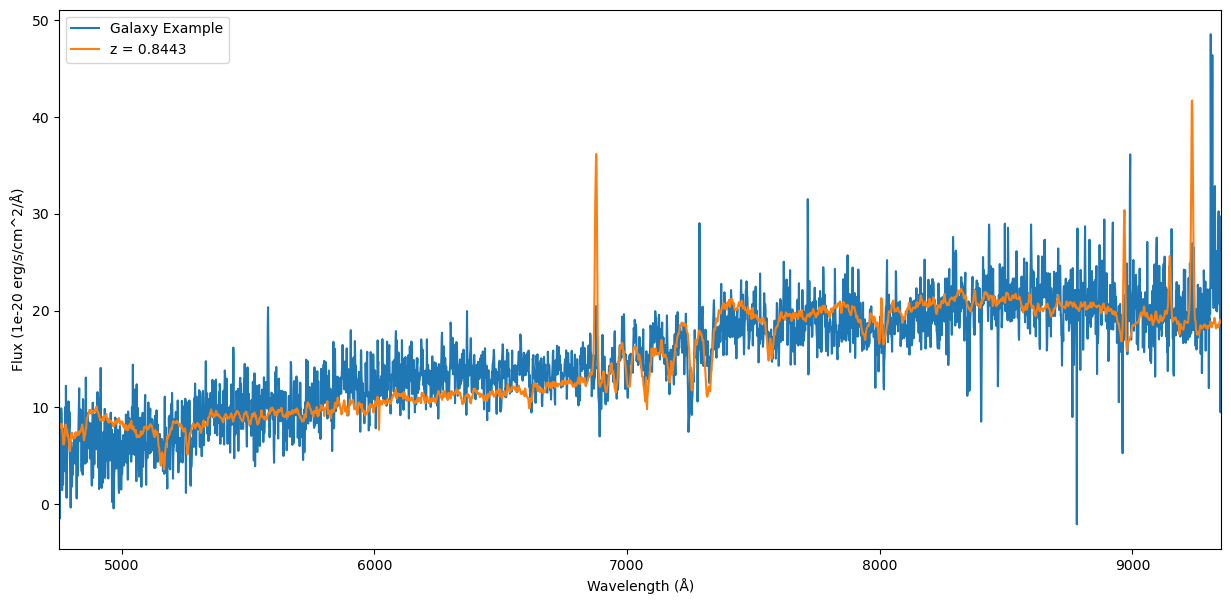

In [56]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_arr[idx][n_lower:n_upper], gal_spec[idx][n_lower:n_upper], label='Galaxy Example')

z = z_arr[np.argmin(red_chi_sq_arr)]

print(z, np.min(red_chi_sq_arr))

c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr[idx][n_lower:n_upper])

ax.plot(wav_arr[idx][n_lower:n_upper], 
        model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, 
        label='z = ' + str(np.round(z,4)))

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux (1e-20 erg/s/cm^2/Å)')

ax.set_xlim(wav_lower, wav_upper)

#ax.set_ylim(0,7.2)

ax.legend()

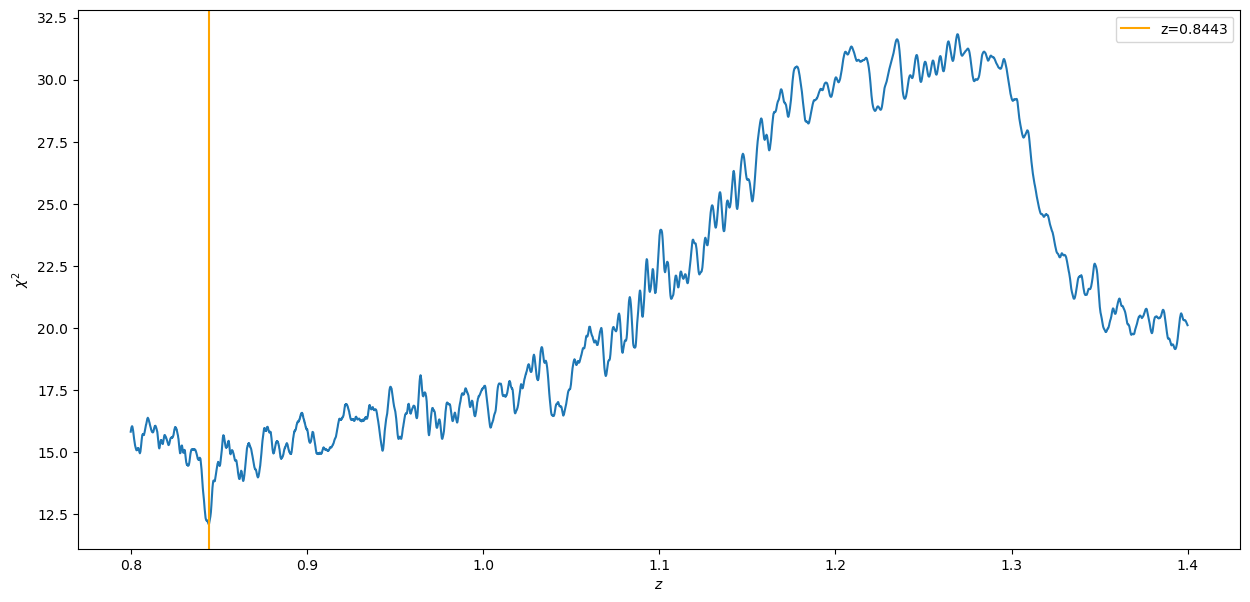

In [57]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(z_arr, red_chi_sq_arr)
ax.axvline(z_arr[np.argmin(red_chi_sq_arr)],color='orange', label='z='+'%0.4f'%(np.round(z_arr[np.argmin(red_chi_sq_arr)],4)))

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\chi^2$')
ax.legend()

Look for another specific solution

In [58]:
z_arr_slice = z_arr[(z_arr>=1.27)&(z_arr<1.28)]
red_chi_sq_arr_slice = red_chi_sq_arr[(z_arr>=1.27)&(z_arr<1.28)]

In [59]:
z_next_best = z_arr_slice[np.argmin(red_chi_sq_arr_slice)]

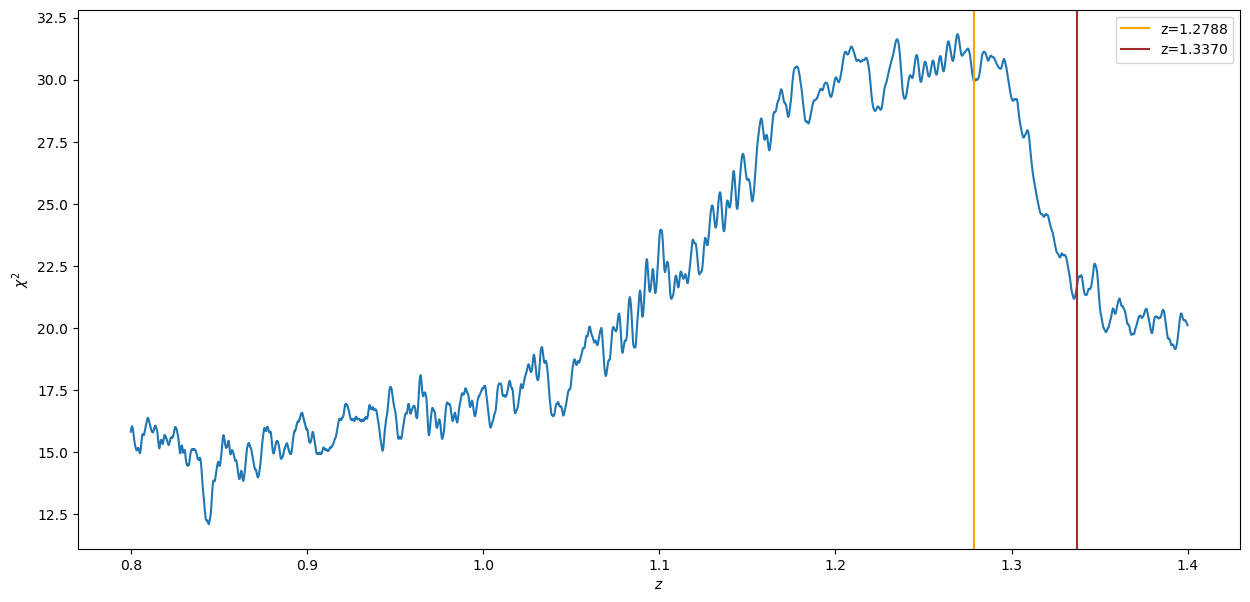

In [60]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(z_arr, red_chi_sq_arr)
ax.axvline(z_next_best,color='orange', label='z='+'%0.4f'%(np.round(z_next_best,4)))
ax.axvline(1.337, color='brown', label='z=1.3370')

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\chi^2$')
#ax.set_xlim(0.84, 0.85)
#ax.set_ylim(11.08, 11.20)
ax.legend()

In [164]:
z_next_best = z_arr_slice[np.argmin(red_chi_sq_arr_slice)]

In [165]:
z_next_best

1.2746000000000393

In [166]:
model_idx = np.where(z_arr==z_next_best)[0][0]

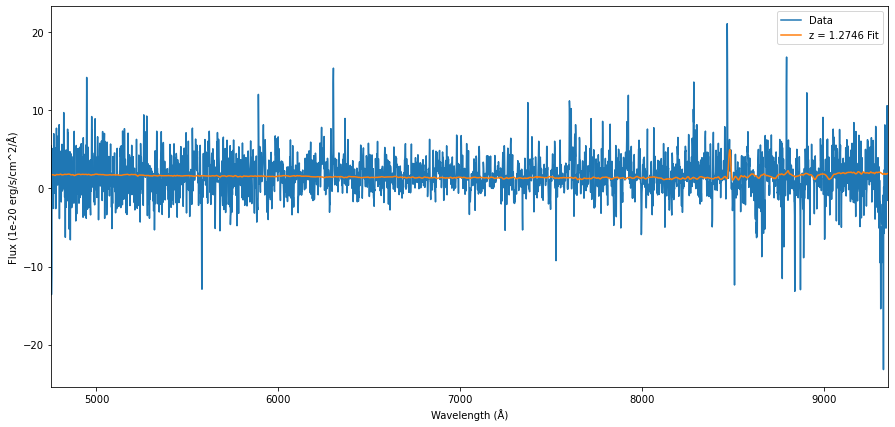

In [167]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.plot(wav_arr[idx][n_lower:n_upper], gal_spec[idx][n_lower:n_upper], label='Data')

z = z_next_best

c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav_arr[idx][n_lower:n_upper])

ax.plot(wav_arr[idx][n_lower:n_upper], 
        model_params[model_idx ,0]*c1_shift + model_params[model_idx ,1]*c2_shift + model_params[model_idx ,2]*c3_shift + model_params[model_idx ,3]*c4_shift, 
        label='z = ' + str(np.round(z,4)) + ' Fit')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux (1e-20 erg/s/cm^2/Å)')

ax.set_xlim(wav_lower, wav_upper)

#ax.set_ylim(0,7.2)

ax.legend()

Load in the atomic lines

In [168]:
atom_lines = np.loadtxt('/Users/thepoetoftwilight/Documents/CUBS/pabs0/data/linelists/galaxy.dat',
                       dtype=str)

In [169]:
atom_lines_names = atom_lines[:,1]

In [170]:
atom_lines_wavs = np.float_(atom_lines[:,0])

In [171]:
atom_line_types = atom_lines[:,2]

In [172]:
atom_line_legends = [atom_lines_names[i]+str(int(np.round(atom_lines_wavs[i]))) for i in range(len(atom_lines_names))]

In [173]:
color_dict = {'a': 'red', 'e': 'blue', 'b': 'gray'}

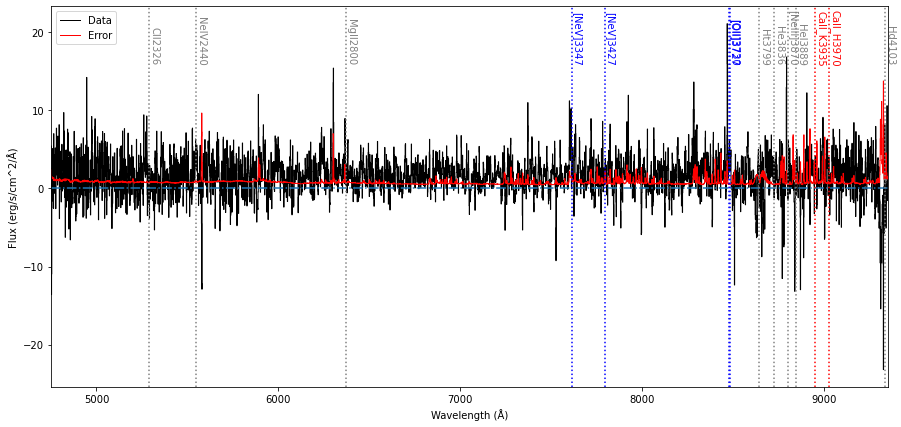

In [174]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.step(wav_arr, gal_spec, label='Data', color='black', lw=1, where='mid')
ax.step(wav_arr, gal_spec_err, label='Error', color='red', lw=1, where='mid')

ax.axhline(0, linestyle='-.')

x_lo = wav_arr[0]
x_hi = wav_arr[-1]

#x_lo = 5500
#x_hi = 5700

for j in range(len(atom_line_legends)):

    wav_pos = atom_lines_wavs[j]*(1+z_next_best)
    line_label = atom_line_legends[j]
    line_type = atom_line_types[j]

    if(wav_pos>=x_lo and wav_pos<=x_hi):
        
        ax.text(wav_pos, np.nanmax(gal_spec)-5, line_label, rotation=270, color=color_dict[line_type])
        ax.axvline(wav_pos, color=color_dict[line_type], linestyle=':')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Flux (erg/s/cm^2/Å)')

ax.set_xlim(x_lo,x_hi)
#ax.set_ylim(-.5,10)

ax.legend()